In [27]:
import pandas as pd

# 读取CSV文件
file_path = 'data/4h/BTC.csv'  # 替换为你的CSV文件路径
df = pd.read_csv(file_path)

# 为数据集添加列名
columns = ['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 
           'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 
           'TakerBuyQuoteAssetVolume', 'Ignore']
df.columns = columns

# 计算涨幅百分比
df['Change'] = ((df['Close'] - df['Open']) / df['Open']) * 100

# 计算HighChange
df['HighChange'] = ((df['High'] - df['Close']) / df['Close']) * 100

# 计算LowChange
df['LowChange'] = ((df['Low'] - df['Close']) / df['Close']) * 100

# 计算VolChange
# 首先，我们需要计算每个Volume与前一个Volume的差异
df['VolumeChange'] = df['Volume'].diff()
# 然后，我们计算这些差异的百分比
df['VolChange'] = ((df['VolumeChange'] / df['Volume'].shift(1)) * 100).fillna(0)
# 注意：对于第一行，由于没有前一个Volume，我们将其设置为0

# 保存到新的CSV文件（如果需要）
output_file_path = 'Processed_Data/4h/BTC.csv'  # 替换为你要保存的文件路径
df.to_csv(output_file_path, index=False)


C:\Users\wangx\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32920 (\N{CJK UNIFIED IDEOGRAPH-8098}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wangx\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wangx\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wangx\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21017 (\N{CJK UNIFIED IDEOGRAPH-5219}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\wangx\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py

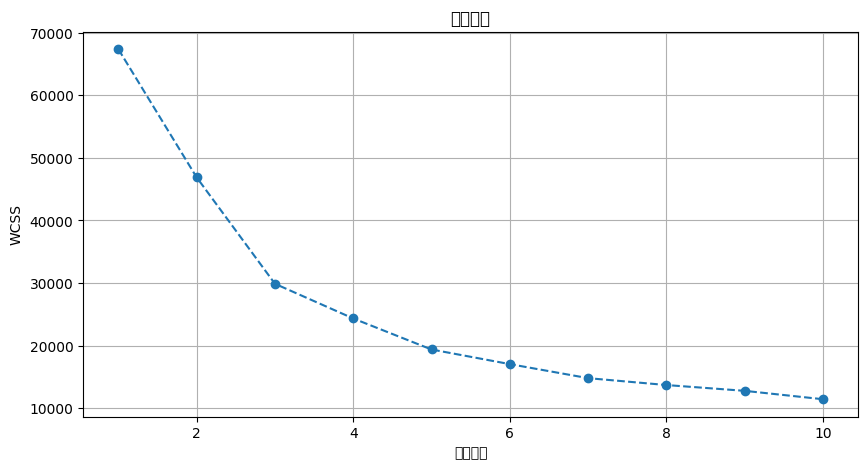

            Change            HighChange             LowChange          
               min        max        min        max        min       max
cluster                                                                 
0        -1.868728   3.786960   0.000000   4.605453  -6.619267 -1.116417
1        -3.817182   1.388045   1.084337   6.897908  -6.256357  0.000000
2        -3.569716  14.748983   0.000000  11.949273 -26.805889 -3.581507
3       -20.480826   0.921818   3.973895  26.249792 -11.096816  0.000000
4        -1.148284   1.123759   0.000000   2.611723  -2.659308  0.000000


In [52]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'Processed_Data/4h/BTC.csv'  # 替换为你的CSV文件路径
df = pd.read_csv(file_path)

# 确保您已经有了以下特征列
# 'Change', 'HighChange', 'LowChange', 'VolChange'
features = ['Change', 'HighChange','LowChange']

# 使用KMeans的肘部法则来确定最佳的簇数
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df[features])
    wcss.append(kmeans.inertia_)


# 绘制肘部图表
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('肘部法则')
plt.xlabel('簇的数量')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 7  # 假设我们通过肘部图表决定最佳的簇数是3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[features])

# 找到每个簇的涨幅范围
cluster_ranges = df.groupby('cluster')[features].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges)

# 保存到新的CSV文件（如果需要）
output_file_path = 'Processed_Data/4h/BTC_clustered.csv'  # 替换为你要保存的文件路径
df.to_csv(output_file_path, index=False)


In [53]:
import pandas as pd
import numpy as np

# 读取CSV文件
file_path = 'Processed_Data/4h/BTC_clustered.csv'  # 替换为你的CSV文件路径
df = pd.read_csv(file_path)

# 初始化一个字典来存储相同Cluster组的第六个Change数据
cluster_groups = {}

# 遍历数据集，每组取五个数据点
for i in range(0, len(df) - 3):  # 减去5确保至少有六个数据点用于最后一组
    # 前五个数据来自Cluster列
    cluster_group = tuple(df['cluster'].iloc[i:i+3])
    
    # 第六个数据来自Change列
    sixth_data_change = df['Change'].iloc[i+3]
    
    # 检查这个Cluster组是否已经在字典中
    if cluster_group in cluster_groups:
        # 如果在，将第六个Change数据加入到对应的列表中
        cluster_groups[cluster_group]['changes'].append(sixth_data_change)
        if sixth_data_change > 0:
            cluster_groups[cluster_group]['positive_count'] += 1
    else:
        # 如果不在，创建一个新的键，并将第六个Change数据作为一个列表的元素
        cluster_groups[cluster_group] = {'changes': [sixth_data_change], 'positive_count': 0}
        if sixth_data_change > 0:
            cluster_groups[cluster_group]['positive_count'] = 1

# 计算每个Cluster组第六个Change数据的平均值和正数百分比
results = {}
for cluster_group, data in cluster_groups.items():
    average_change = np.mean(data['changes'])
    positive_percentage = (data['positive_count'] / len(data['changes'])) * 100
    results[cluster_group] = (average_change, positive_percentage, len(data['changes']))

# 过滤count<10的集群组，并按照Positive Change Percentage从大到小排列
filtered_results = {k: v for k, v in results.items() if v[2] >= 10}
sorted_results = sorted(filtered_results.items(), key=lambda x: x[1][1], reverse=True)

# 打印每个Cluster组及其第六个Change数据的平均值、正数百分比和数据点数量
for cluster_group, (average_change, positive_percentage, data_count) in sorted_results:
    print(f"Cluster Group: {cluster_group}, Average Sixth Data Change: {average_change:.2f}, Positive Change Percentage: {positive_percentage:.2f}%, Data Count: {data_count}")


Cluster Group: (3, 4, 1), Average Sixth Data Change: 0.26, Positive Change Percentage: 70.00%, Data Count: 10
Cluster Group: (1, 0, 3), Average Sixth Data Change: 0.82, Positive Change Percentage: 69.57%, Data Count: 23
Cluster Group: (0, 3, 0), Average Sixth Data Change: 0.85, Positive Change Percentage: 69.23%, Data Count: 26
Cluster Group: (2, 1, 0), Average Sixth Data Change: 0.68, Positive Change Percentage: 66.67%, Data Count: 33
Cluster Group: (1, 4, 1), Average Sixth Data Change: 0.03, Positive Change Percentage: 64.93%, Data Count: 134
Cluster Group: (4, 2, 1), Average Sixth Data Change: 0.21, Positive Change Percentage: 64.71%, Data Count: 17
Cluster Group: (4, 3, 1), Average Sixth Data Change: -0.77, Positive Change Percentage: 64.29%, Data Count: 14
Cluster Group: (2, 1, 1), Average Sixth Data Change: 0.47, Positive Change Percentage: 64.00%, Data Count: 25
Cluster Group: (3, 1, 3), Average Sixth Data Change: 1.05, Positive Change Percentage: 63.64%, Data Count: 11
Cluster 